In [15]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os

from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [8, 6]
from metavision_core.event_io import RawReader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load recordings from the dataset


In [ ]:
from dataset import load_dir

raws_loaded = load_dir('uvled_freq_dataset/recordings/', subfolders=('0','45'))

raws_loaded.keys()

dict_keys(['20k', '__25Hz', '2.5k', '__100Hz', '5k', '__50Hz', '10k', '1k', '__10Hz', '30k', '__250Hz', '__500Hz'])

### Load the events from the RAW recordings

In [17]:
from copy import copy

__freqs = ["__10Hz", "__25Hz", "__50Hz", "__100Hz", "__250Hz", "__500Hz", "1k", "2.5k", "5k", "10k", "20k", "30k"]

raws = {k: raws_loaded[k] for k in __freqs}

events = {k: copy(v) for k, v in raws.items()}

from dataset import apply
from util import raw_load_events

apply(raw_load_events, events, dtime = 5000, start_ts=0.25 * 1e6)

print(events["2.5k"])

{'1_5': [array([( 983, 387, 0,    9), ( 983, 387, 0,   10), ( 983, 387, 0,   10),
       ..., (1109, 398, 1, 4987), ( 982, 385, 1, 4988),
       ( 980, 389, 1, 4995)],
      dtype={'names': ['x', 'y', 'p', 't'], 'formats': ['<u2', '<u2', '<i2', '<i8'], 'offsets': [0, 2, 4, 8], 'itemsize': 16}), array([(521, 379, 0,    1), (521, 379, 0,    1), (674, 385, 0,    4), ...,
       (679, 387, 1, 4989), (516, 379, 1, 4996), (675, 388, 1, 4997)],
      dtype={'names': ['x', 'y', 'p', 't'], 'formats': ['<u2', '<u2', '<i2', '<i8'], 'offsets': [0, 2, 4, 8], 'itemsize': 16}), array([(283, 392, 1,   21), (153, 379, 1,   23), (156, 381, 1,   44), ...,
       (155, 382, 0, 4998), (155, 382, 0, 4999), (155, 382, 0, 4999)],
      dtype={'names': ['x', 'y', 'p', 't'], 'formats': ['<u2', '<u2', '<i2', '<i8'], 'offsets': [0, 2, 4, 8], 'itemsize': 16})], '1': [array([( 961, 376, 1,    1), (1145, 395, 1,    5), (1150, 392, 1,    6),
       ..., ( 358, 241, 0, 4987), (1150, 391, 1, 4989),
       ( 962, 372, 1

### Resample the signal

In [18]:
from util import resample_by_polarity

apply(resample_by_polarity, events)

events["2.5k"]["0_5"][0]

events["30k"]["0_5"][0]

array([0., 0., 0., ..., 0., 0., 1.])

### Plot the relationship between the number of events per period x the disatance

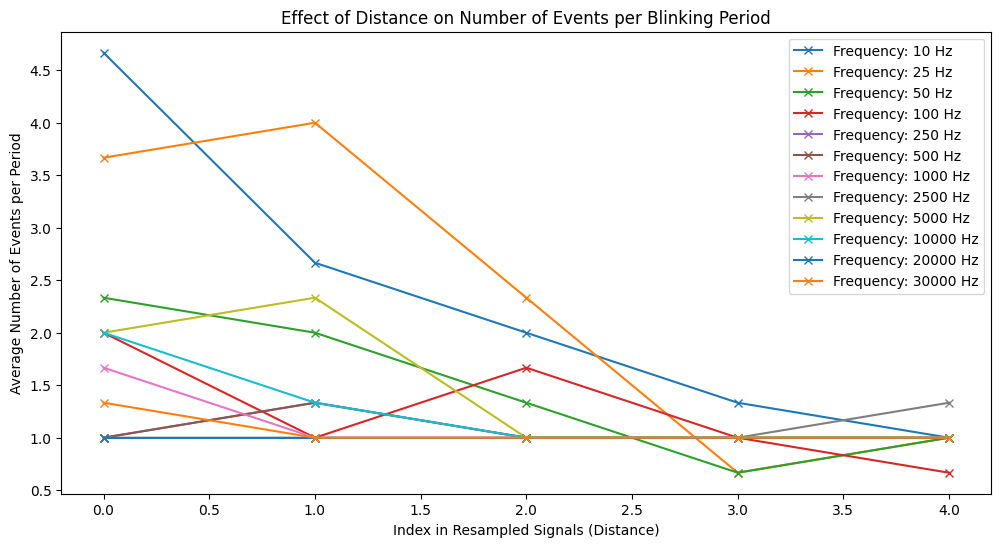

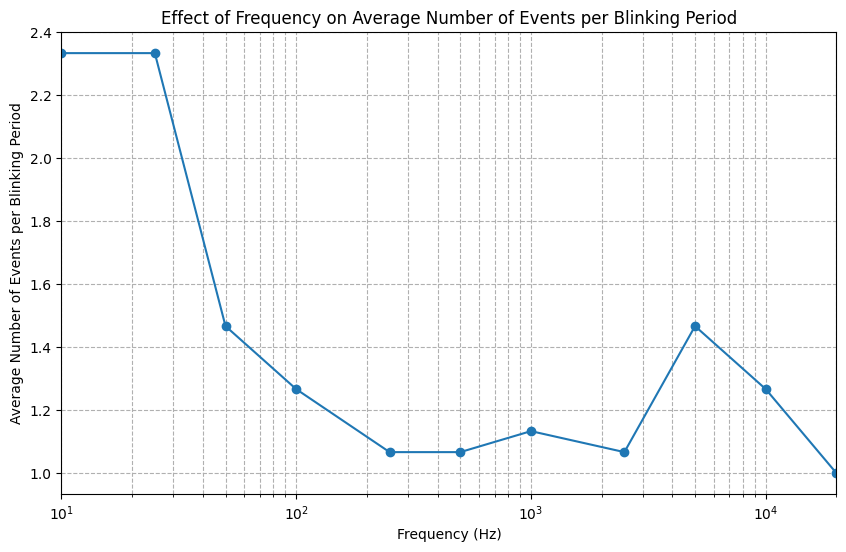

In [19]:
from plotting import plot_avg_events_per_distance, plot_avg_events_per_frequency

frequencies = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000, 20000, 30000]

plot_avg_events_per_distance(events, frequencies)

plot_avg_events_per_frequency(events, frequencies)